# Lending club credit risk anlysis

In [1]:
# Library imports
# For numarical array based calculations
import numpy as np
# For handling data frame which is crucial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# Loading the data with explicit delimiter as "," (the data file contains ,)
# The below statement assume that loan.csv is in current path
df = pd.read_csv("loan.csv", delimiter=",", header=0, low_memory=False)


## Data clean up

In [3]:
# A precautionary step to remove the leading and trailing spaces in column names
df.columns.str.strip()

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)

In [4]:
# Finding the percentage of empty values in each column
cols_percentage = round(df.isnull().sum()*100/df.shape[0])

# Filtering those columns whose percentage of empty values is more than 25%  (Let us consider a quarter)
cols_to_remove = cols_percentage[cols_percentage > 25]

In [5]:
# Dropping the columns whose percentage of empty values are more than 25%
df.drop(cols_to_remove.index, axis = 1, inplace = True)

In [6]:
#Find the columns which contains single values across all the rows.  
#When the column contains all rows with same values, it is not much usefull for statistical analysis
col_unique_values = df.nunique()
col_unique_values_one = col_unique_values[col_unique_values == 1]
col_unique_values_one

pymnt_plan                    1
initial_list_status           1
collections_12_mths_ex_med    1
policy_code                   1
application_type              1
acc_now_delinq                1
chargeoff_within_12_mths      1
delinq_amnt                   1
tax_liens                     1
dtype: int64

In [7]:
# Remove the columns which just contains the one value across all the rows as found above
df.drop(col_unique_values_one.index, axis=1, inplace=True)

In [8]:
# Let us eliminate the string columns and whose values are different in each row. 
# The maximum number of unique valued columns which are type string
# Find the maximum unique valued columns
df.nunique().sort_values(ascending=False).head(15)

id                 39717
url                39717
member_id          39717
total_pymnt        37850
total_pymnt_inv    37518
total_rec_int      35148
last_pymnt_amnt    34930
emp_title          28820
revol_bal          21711
title              19615
installment        15383
funded_amnt_inv     8205
total_rec_prncp     7976
annual_inc          5318
recoveries          4040
dtype: int64

**The columns emp_title and title columns are string and containing maximum unique values.  We can remove them**

In [9]:
df.drop(['emp_title', 'title'], axis=1, inplace=True)

**The columns 'id', 'url' and 'member_id'** have the count of unique values equal to number of rows in the data frame.  Hence they are the candidate for indexing.  Let us keep only "id" and remove other two candidates.

In [10]:
df.drop(['url', 'member_id'], axis=1, inplace=True)

In [11]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,10+ years,...,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,May-16,0.0
1,1077430,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,...,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0
2,1077175,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,10+ years,...,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,May-16,0.0
3,1076863,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,10+ years,...,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16,0.0
4,1075358,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,1 year,...,3513.33,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,May-16,0.0


In [12]:
#Finding the null values rows 
missing_rows = round(100*(df.isnull().sum()/len(df.index)),2)
missing_rows[missing_rows>0]

emp_length              2.71
revol_util              0.13
last_pymnt_d            0.18
last_credit_pull_d      0.01
pub_rec_bankruptcies    1.75
dtype: float64

In [13]:
#Dropping rows of above displayed null valued ones
df.dropna(subset=['emp_length', 'revol_util', 'last_pymnt_d', 'last_credit_pull_d','pub_rec_bankruptcies'], inplace=True)
missing_rows = round(100*(df.isnull().sum()/len(df.index)), 2)
missing_rows[ missing_rows > 0 ]

Series([], dtype: float64)

In [14]:
# Removing all the trailing and leading spaces in the values if they are type string (object)

for i in df.columns:
# checking datatype of each columns
    if df[i].dtype == 'object':
    
        # applying strip function on column
        df[i] = df[i].map(str.strip)

As we are interested in analyzing the variables contributing to loan defaulters, we can ignore the data related to "loan_status" containing values = current. 

In [15]:
df = df[df.loan_status != 'Current']

**Dealing with data types**

In [16]:
# Let us find the data types of the columns
df.dtypes

id                           int64
loan_amnt                    int64
funded_amnt                  int64
funded_amnt_inv            float64
term                        object
int_rate                    object
installment                float64
grade                       object
sub_grade                   object
emp_length                  object
home_ownership              object
annual_inc                 float64
verification_status         object
issue_d                     object
loan_status                 object
purpose                     object
zip_code                    object
addr_state                  object
dti                        float64
delinq_2yrs                  int64
earliest_cr_line            object
inq_last_6mths               int64
open_acc                     int64
pub_rec                      int64
revol_bal                    int64
revol_util                  object
total_acc                    int64
out_prncp                  float64
out_prncp_inv       

**int_rate** and **revol_util** are supposed to be numerical and hence let us remove %

In [17]:
df['int_rate'] = df.int_rate.str.strip('%').astype(float)
df['revol_util'] = df.revol_util.str.strip('%').astype(float)

**issue_d**, **earliest_cr_line** supposed to be datetime types

In [18]:
# Translating issue_d and esrliest_cr_line to date values
df['issue_d'] = pd.to_datetime(df.issue_d, format='%b-%y')
df['issue_d'] = df['issue_d'].apply(lambda x: x-pd.DateOffset(years=100) if x.year > 2020 else x)
df['earliest_cr_line'] = pd.to_datetime(df.earliest_cr_line, format='%b-%y')
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: x-pd.DateOffset(years=100) if x.year > 2020 else x)

In [19]:
# just checking the data types are changed
df.dtypes

id                                  int64
loan_amnt                           int64
funded_amnt                         int64
funded_amnt_inv                   float64
term                               object
int_rate                          float64
installment                       float64
grade                              object
sub_grade                          object
emp_length                         object
home_ownership                     object
annual_inc                        float64
verification_status                object
issue_d                    datetime64[ns]
loan_status                        object
purpose                            object
zip_code                           object
addr_state                         object
dti                               float64
delinq_2yrs                         int64
earliest_cr_line           datetime64[ns]
inq_last_6mths                      int64
open_acc                            int64
pub_rec                           

**For the datetime columns, let us create the derived columns for year, month, day, week etc**

In [20]:
df['issue_d_year'] = df.issue_d.dt.year
df['issue_d_month'] = df.issue_d.dt.strftime('%b')
df['issue_d_weekday'] = df.issue_d.dt.weekday
df['issue_d_year'] = df['issue_d_year'].astype(object)
df['issue_d_weekday'] = df['issue_d_weekday'].astype(object)
df['earliest_cr_line_year'] = df.earliest_cr_line.dt.year
df['earliest_cr_line_month'] = df.earliest_cr_line.dt.strftime('%b')
df['earliest_cr_line_year'] = df['earliest_cr_line_year'].astype(object)

In [21]:
df.dtypes

id                                  int64
loan_amnt                           int64
funded_amnt                         int64
funded_amnt_inv                   float64
term                               object
int_rate                          float64
installment                       float64
grade                              object
sub_grade                          object
emp_length                         object
home_ownership                     object
annual_inc                        float64
verification_status                object
issue_d                    datetime64[ns]
loan_status                        object
purpose                            object
zip_code                           object
addr_state                         object
dti                               float64
delinq_2yrs                         int64
earliest_cr_line           datetime64[ns]
inq_last_6mths                      int64
open_acc                            int64
pub_rec                           

## Univariate Analysis ##

**Loan Amount distribution**

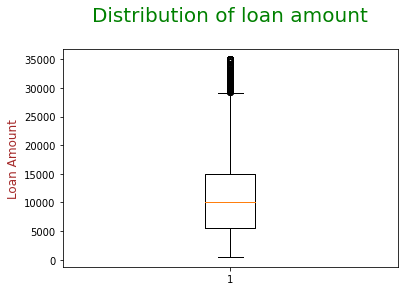

In [22]:
plt.boxplot([df.loan_amnt])
plt.title("Distribution of loan amount\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.ylabel("Loan Amount", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.show()

In [23]:
round(df.loan_amnt.describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]),2)

count    36737.00
mean     11153.35
std       7368.34
min        500.00
5%        2400.00
10%       3200.00
25%       5500.00
50%      10000.00
75%      15000.00
90%      22000.00
95%      25000.00
99%      35000.00
max      35000.00
Name: loan_amnt, dtype: float64

**Analysis**
From the above plots, more number of people took loan amount of 10000, and also meadian of distribution is 10000. And very few people took more than 30000 loan amount which could be outlier

**Committed Amount distribution**

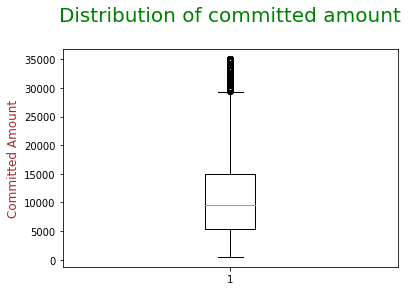

In [24]:
plt.boxplot([df.funded_amnt])
plt.title("Distribution of committed amount\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.ylabel("Committed Amount", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.show()

In [25]:
round(df.funded_amnt.describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]),2)

count    36737.00
mean     10884.14
std       7107.27
min        500.00
5%        2400.00
10%       3200.00
25%       5425.00
50%       9600.00
75%      15000.00
90%      20375.00
95%      25000.00
99%      35000.00
max      35000.00
Name: funded_amnt, dtype: float64

**Analysis**
The behaviour is some what similar to loan amount.  This means the applied loan amount is committed for most cases

**Invested amount distribution**

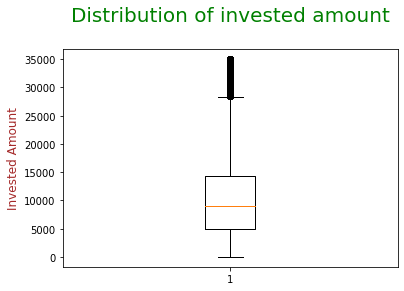

In [26]:
plt.boxplot([df.funded_amnt_inv])
plt.title("Distribution of invested amount\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.ylabel("Invested Amount", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.show()

In [27]:
round(df.funded_amnt_inv.describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]),2)

count    36737.00
mean     10444.16
std       7008.22
min          0.00
5%        2000.00
10%       3000.00
25%       5000.00
50%       9000.00
75%      14351.55
90%      20000.00
95%      24658.31
99%      34725.00
max      35000.00
Name: funded_amnt_inv, dtype: float64

**Analysis**
When compare the three box plots of Invested amount, loan amount and committed amount in majority of the cases the investors are investing for the loan

**Interest rate distribution**

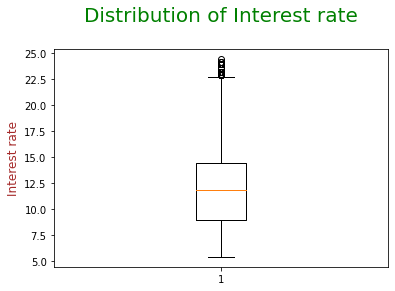

In [28]:
plt.boxplot([df.int_rate])
plt.title("Distribution of Interest rate\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.ylabel("Interest rate", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.show()

In [29]:
round(df.int_rate.describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]),2)

count    36737.00
mean        11.98
std          3.70
min          5.42
5%           6.17
10%          7.14
25%          8.94
50%         11.83
75%         14.46
90%         16.82
95%         18.39
99%         20.99
max         24.40
Name: int_rate, dtype: float64

**Analysis**
Most of the interest rates appearing between 8.94 and 14.46.  Few people took the loan at 22.5% and above

**Analysis of installment**

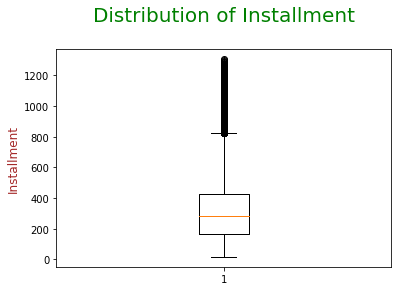

In [30]:
plt.boxplot([df.installment])
plt.title("Distribution of Installment\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.ylabel("Installment", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.show()

In [31]:
round(df.installment.describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]),2)

count    36737.00
mean       324.99
std        208.84
min         16.08
5%          73.28
10%        100.64
25%        167.73
50%        280.28
75%        429.45
90%        622.66
95%        763.37
99%        933.11
max       1305.19
Name: installment, dtype: float64

**Analysis**
Most of the installement are with in 167 to 429. When we take the median it is 280.28 which is most representative value

**Analyisis of loan term fequency distribution**
Since it is categorical let us plot the bar chart

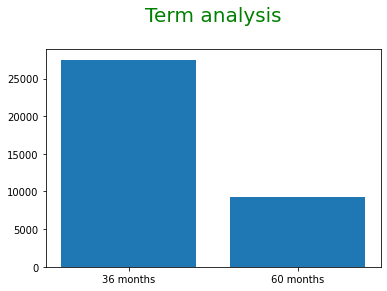

In [32]:
var = 'term'
# Calculating distribution of loan issued year and number of loans
vals = df[var].value_counts()
plt.title("Term analysis\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.bar(vals.index, vals)
plt.show()

**Analysis**
As per the above bar almost majority of the borrowers are opting for 36 months installments

**Analysis of annual income**

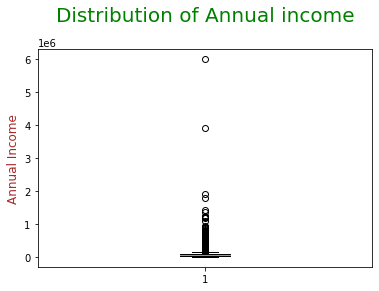

In [33]:
plt.boxplot([df.annual_inc])
plt.title("Distribution of Annual income\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.ylabel("Annual Income", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.show()

In [34]:
round(df.annual_inc.describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]),2)

count      36737.00
mean       69467.23
std        64062.56
min         4000.00
5%         24000.00
10%        30000.00
25%        41200.00
50%        60000.00
75%        83000.00
90%       117000.00
95%       142000.00
99%       235000.00
max      6000000.00
Name: annual_inc, dtype: float64

**Analysis** 
The representative annual income range is (inter quartile range) is 41200 to 83000.  The representaive value is 60000

**Analysis of DTI (Debt to income ratio)**

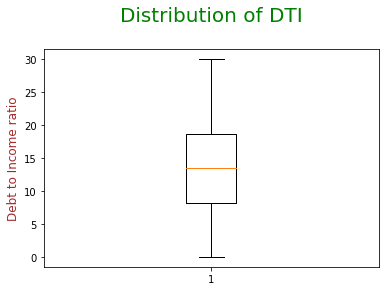

In [35]:
plt.boxplot([df.dti])
plt.title("Distribution of DTI\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.ylabel("Debt to Income ratio", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
plt.show()

In [36]:
round(df.dti.describe(percentiles=[0.1,0.25,0.5,0.75,0.9,0.95,0.99]),2)

count    36737.00
mean        13.34
std          6.65
min          0.00
10%          4.15
25%          8.22
50%         13.43
75%         18.59
90%         22.32
95%         23.81
99%         26.55
max         29.99
Name: dti, dtype: float64

**Analysis**
There is no outliers in this distribution.  The lending investors are giviling to loan to borrowers who are well below DTI ratio of 30

**Analysis of loan issue date**

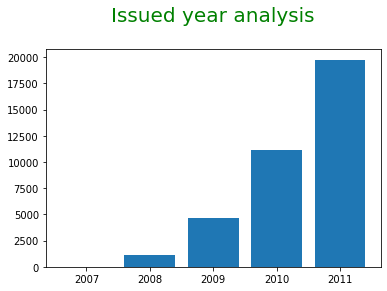

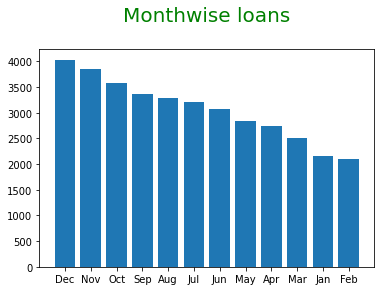

In [37]:
var = 'issue_d_year'
# Calculating distribution of loan issued year and number of loans
vals = df[var].value_counts()
plt.title("Issued year analysis\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.bar(vals.index, vals)
plt.show()

var = 'issue_d_month'

# Calculating distribution of loan issued month and number of loans
vals = df[var].value_counts()
plt.title("Monthwise loans\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.bar(vals.index, vals)
plt.show()

**Analysis**
Almost loans issued are doubled each year.
Most of the loans are issued at last three months

**Analysis of employment period**

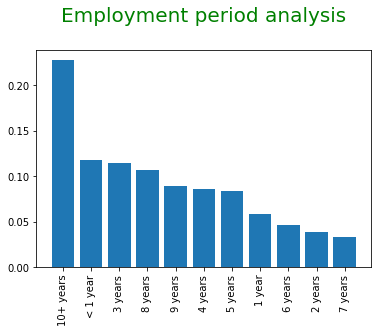

In [38]:
emp = 'emp_length'
# Calculating distribution of loan issued year and number of loans
prob_df = df[emp].value_counts(normalize=True).reset_index()
plt.title("Employment period analysis\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.bar(df[emp].unique(), prob_df[emp])
plt.xticks(rotation=90)
plt.show()

**Analysis**
It is evident from the above graph that most of the borrowers have employment length of 10+ years

**Analysis of home ownership**

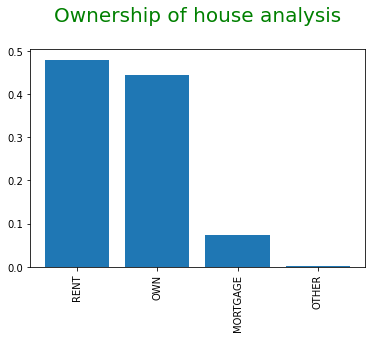

In [39]:
var = 'home_ownership'
prob_df = df[var].value_counts(normalize=True).reset_index()
plt.title("Ownership of house analysis\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.bar(df[var].unique(), prob_df[var])
plt.xticks(rotation=90)
plt.show()

**Analysis**
The borrowers who are rented are slightly higher than own house

**Analysis of verification status**

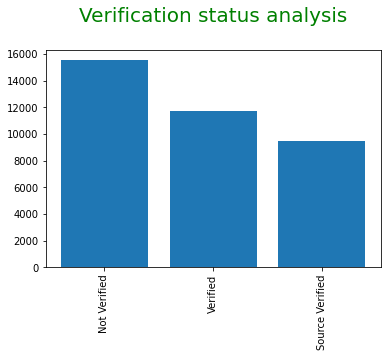

In [40]:
var = 'verification_status'
vals = df[var].value_counts()
plt.title("Verification status analysis\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.bar(vals.index, vals)
plt.xticks(rotation=90)
plt.show()

**Analysis**
It is observed that the number of loans which are not veified are more

**Analysis of loan status**

In [41]:
df.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies', 'issue_d_year', 'issue_d_month',
       'issue_d_weekday', 'earliest_cr_line_year', 'earliest_cr_line_month'],
      dtype='object')

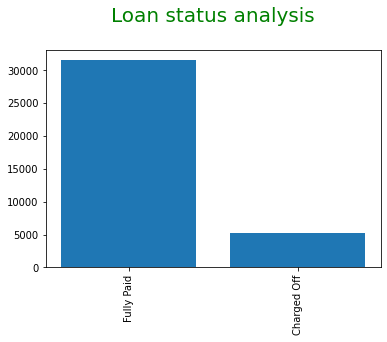

In [42]:
var = 'loan_status'
vals = df[var].value_counts()
plt.title("Loan status analysis\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.bar(vals.index, vals)
plt.xticks(rotation=90)
plt.show()

**Analysis**
Almost 15% of borrowers are defaulted

**Analysis of purpose**

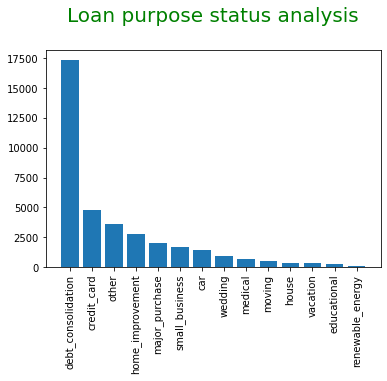

In [43]:
var = 'purpose'
vals = df[var].value_counts()
plt.title("Loan purpose status analysis\n", fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
plt.bar(vals.index, vals)
plt.xticks(rotation=90)
plt.show()

**Analysis**
Most of the borrowers taking loan for debt consilidation

## Bivariate Analysis ##

The univariate analysis so far we have done above gave how individual borrower variables and lender variables are distributed.
Let us now perform the Bivariate Analysis to understand how each variable is moving with others, that means how each variables are depending on others.
**We are interested how each variable is influencing the defaulters**

**Correlation matrix to first understand how variables are correlated**

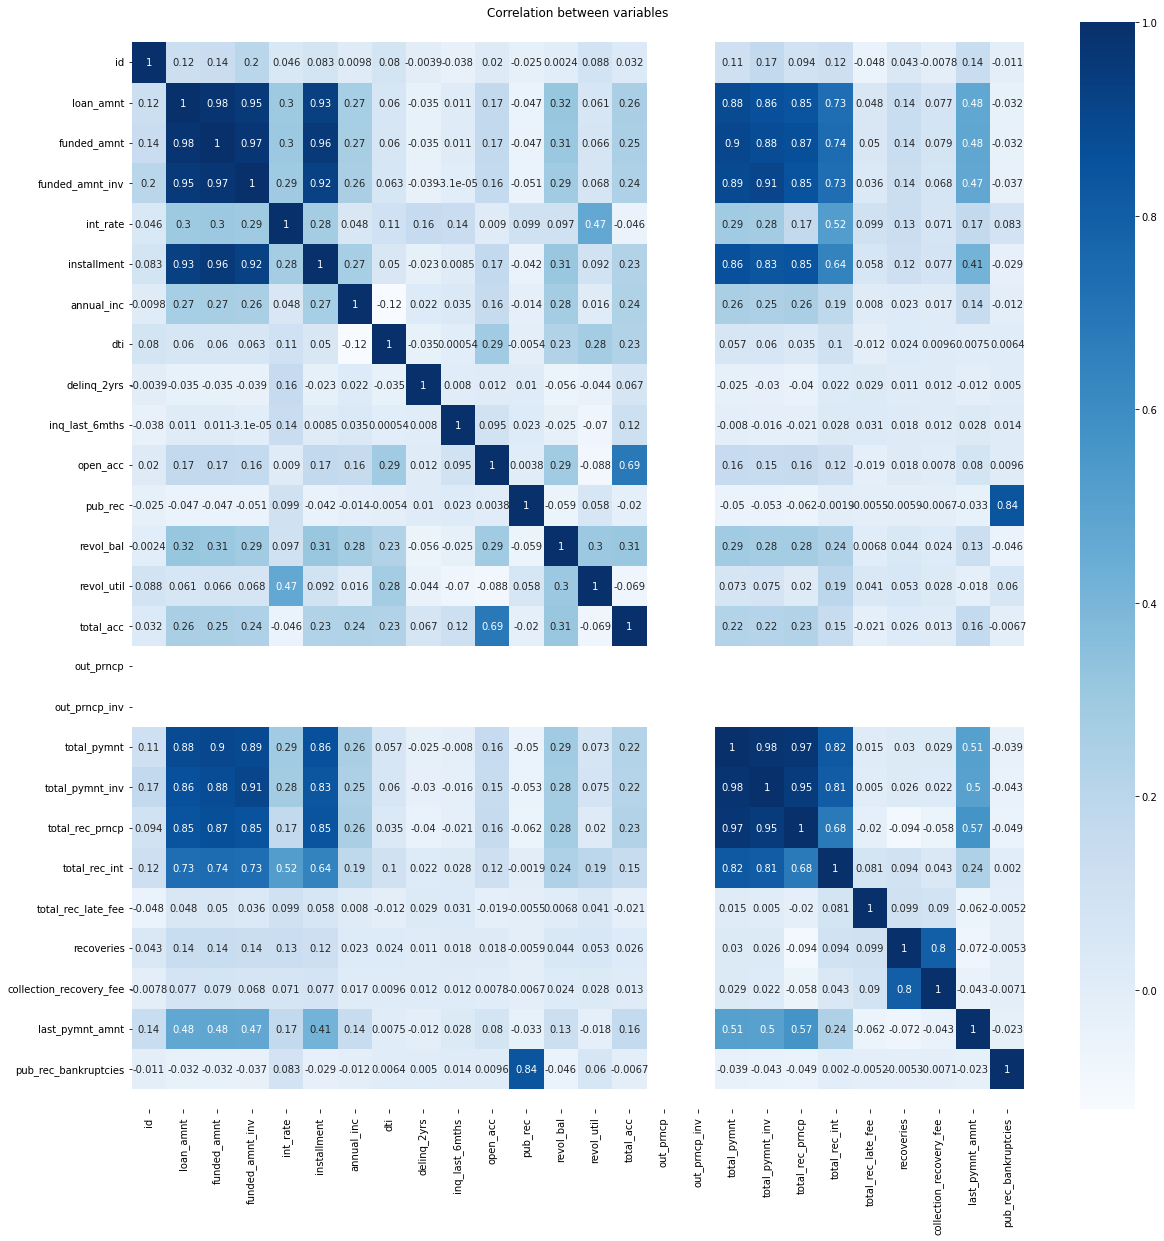

In [44]:
# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(20,20))
# Producing the heat map
ax = sb.heatmap(corr_matrix, annot = True, cmap='Blues')
top, bottom = ax.get_ylim()
ax.set_ylim(top+0.5, bottom-0.5)
plt.title("Correlation between variables")
plt.show()

**Effect of term on loan status**

C:\Users\ryeddla\AppData\Local\Temp/ipykernel_4884/2386973035.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  frame['proportion'] = frame.groupby('term').transform(lambda x: x/x.sum())


<AxesSubplot:xlabel='term', ylabel='proportion'>

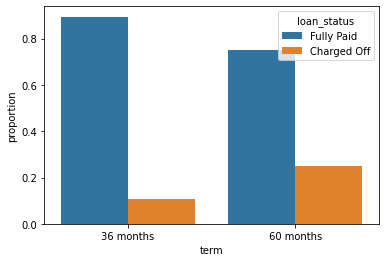

In [45]:
frame = df.groupby(['term', 'loan_status'], as_index=False)['id'].count()
frame['proportion'] = frame.groupby('term').transform(lambda x: x/x.sum())
sb.barplot(x='term', y='proportion', hue='loan_status', data=frame, hue_order = ['Fully Paid', 'Charged Off'])


**In the 60 months term more percentage of borrowers defaulted**

**Effect of term and loan amount on loan status**

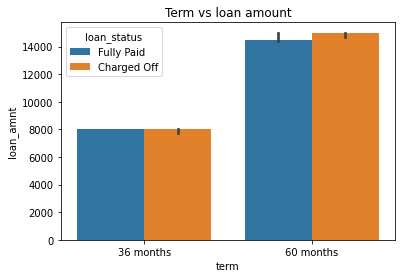

In [46]:
sb.barplot(x='term', y='loan_amnt', hue='loan_status', data=df, estimator=np.median)
plt.title('Term vs loan amount')
plt.show()


**Analysis**
The loan amount does not influence the defaulters in both terms

**Effect of interest rate on loan status**

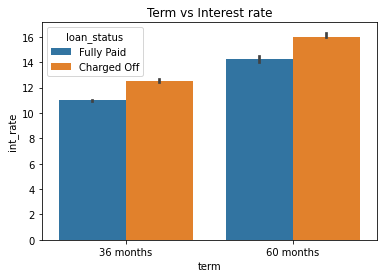

In [47]:
sb.barplot(x='term', y='int_rate', hue='loan_status', data=df, estimator=np.median)
plt.title('Term vs Interest rate')
plt.show()

**Analysis**
Higher interest rates tend to have bit more defaulters

**Effect of employment length of defaulter status**

C:\Users\ryeddla\AppData\Local\Temp/ipykernel_4884/1022242324.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  frame['percentage'] = frame.groupby('emp_length').transform(lambda x: x/x.sum())


Text(0.5, 1.0, 'Grade vs Loan status')

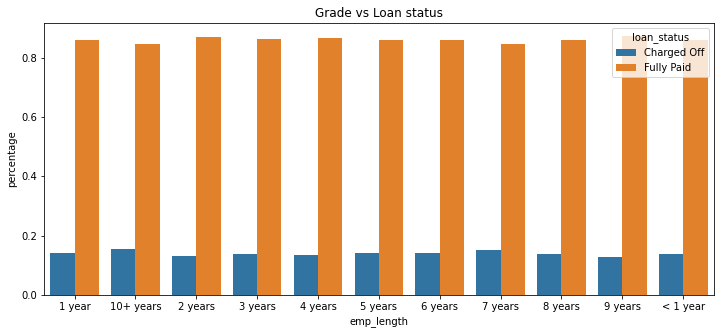

In [48]:
frame = df.groupby(['emp_length', 'loan_status'], as_index=False)['id'].count()
frame['percentage'] = frame.groupby('emp_length').transform(lambda x: x/x.sum())
plt.figure(figsize=(12,5))
sb.barplot(x='emp_length', y='percentage', hue='loan_status', data=frame)
plt.title('Grade vs Loan status')

**Analysis**
The length of the employment is not having significant impact on defaulter state

**Impact of state of the borrower on defaulter**

Text(0.5, 1.0, 'Address State vs Charged Off')

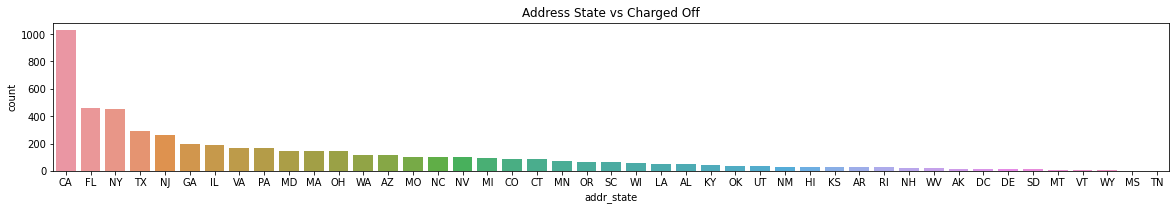

In [49]:
defaulter_df = df[df.loan_status.values == 'Charged Off']
plt.figure(figsize=(20,6))
plt.subplot(211)
sb.countplot(x='addr_state', data=defaulter_df, order=defaulter_df.addr_state.value_counts().index)
plt.title('Address State vs Charged Off')

**Looks like the more defaulters are from CA, FL and NY**

**Impact of verification status on defaulters**

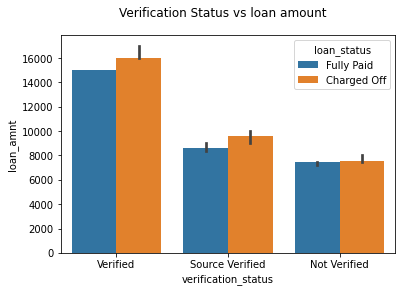

In [50]:
sb.barplot(x='verification_status', y='loan_amnt', hue='loan_status', data=df, estimator=np.median)
plt.suptitle('Verification Status vs loan amount')
plt.show()

**Analysis**
The verification status does not impact much the defaulters

**Impact of purpose on defaulters**

C:\Users\ryeddla\AppData\Local\Temp/ipykernel_4884/371565059.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  frame['percentage'] = frame.groupby('purpose').transform(lambda x: x/x.sum())


Text(0.5, 1.0, 'Impact of purpose on loan status')

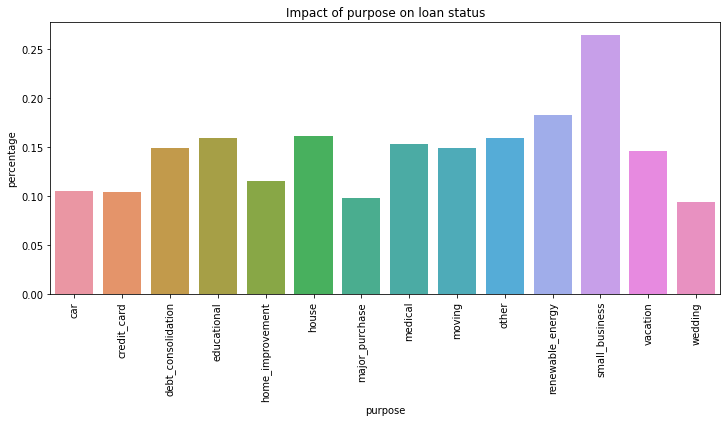

In [51]:
frame = df.groupby(['purpose', 'loan_status'], as_index=False)['id'].count()
frame['percentage'] = frame.groupby('purpose').transform(lambda x: x/x.sum())
frame = frame[frame.loan_status == 'Charged Off']
plt.figure(figsize=(12,5))
sb.barplot(x='purpose', y='percentage', data=frame)
plt.xticks(rotation=90)
plt.title('Impact of purpose on loan status')

**Looks like the 'small_business' purpose has more defaulters**